# 2層のニューラルネットワーク

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

### シグモイド関数（活性化関数）
$ h(x) = \frac{1}{1+exp(-x)} $

In [61]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))    

### ソフトマックス関数（出力層：分類問題）
$ y_k = \frac{exp(a_k)}{\sum_{i=1}^{n}exp(a_i)} $

In [62]:
def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)  # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

### 交差エントロピー誤差（損失関数）
$ E = -\sum_{k}^{n}t_k log(y_k) $

In [63]:
def cross_entropy_error(y, t):
    batch_size = y.shape[0]
    # one-hot形式をインデックス形式に変換
    t_index = t.argmax(axis=1)
    return -np.sum(np.log(y[np.arange(batch_size), t_index] + 1e-7)) / batch_size

### シグモイド関数の勾配
$ \frac{\partial L}{\partial x} = \frac{\partial L}{\partial y} \frac{\partial y}{\partial x} = \frac{\partial L}{\partial y} y(1-y) $

In [64]:
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

### 2層のニューラルネットのクラス

In [65]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

### MNIST データセット

In [66]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

#### 【オプション】入力データの削減

In [ ]:
# 入力データの削減
train_size = 7500
test_size = 2500
x_train = x_train[:train_size]
t_train = t_train[:train_size]
x_test = x_test[:test_size]
t_test = t_test[:test_size]
print(x_train.shape)
print(x_test.shape)

#### 【オプション】入力データの確認

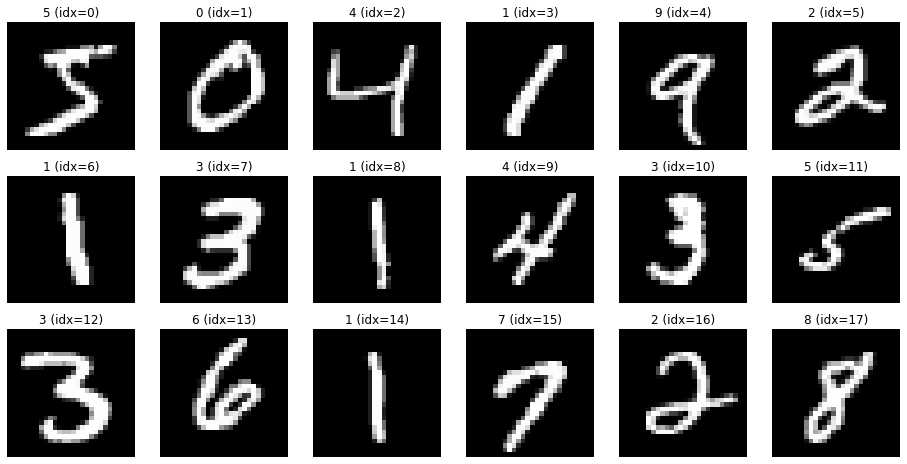

In [67]:
figure = plt.figure(figsize=(16, 8))
rows, cols = 3, 6
for i in range(rows * cols):
    img, label = x_train[i], t_train[i].argmax()
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f'{label} (idx={i})')
    plt.axis('off')
    img = img.reshape(28, 28)  # 28x28 に変換
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

#### クラスのインスタンス化

In [68]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

#### パラメータの定義

In [69]:
epoch_num = 20  # エポック数を設定する
batch_size = 100  # バッチの数
learning_rate = 0.1  # 学習係数

### ミニバッチの学習

In [70]:
train_loss_list = []
train_acc_list = [0.0]
test_acc_list = [0.0]

train_size = x_train.shape[0]  # 訓練データの数
iter_per_epoch = max(int(train_size / batch_size), 1)  # エポック毎の繰り返しの回数
iters_num = iter_per_epoch * epoch_num  # 全体の繰り返しの回数

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % iter_per_epoch == 0:
        epoch_count = int((i + 1) / iter_per_epoch)
        #print(f'epoch({epoch_count}) loss = {train_loss_list[-1]}')
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f'epoch({epoch_count}) accuracy(train, test) = ({train_acc}, {test_acc})')

print('Done!')

epoch(1) accuracy(train, test) = (0.8006333333333333, 0.8032)
epoch(2) accuracy(train, test) = (0.8776333333333334, 0.8822)
epoch(3) accuracy(train, test) = (0.8970833333333333, 0.8993)
epoch(4) accuracy(train, test) = (0.9073333333333333, 0.9092)
epoch(5) accuracy(train, test) = (0.91395, 0.9169)
epoch(6) accuracy(train, test) = (0.9197333333333333, 0.9208)
epoch(7) accuracy(train, test) = (0.9238666666666666, 0.9258)
epoch(8) accuracy(train, test) = (0.9277333333333333, 0.9287)
epoch(9) accuracy(train, test) = (0.9298, 0.9318)
epoch(10) accuracy(train, test) = (0.9334, 0.9342)
epoch(11) accuracy(train, test) = (0.9352666666666667, 0.9358)
epoch(12) accuracy(train, test) = (0.9383166666666667, 0.9384)
epoch(13) accuracy(train, test) = (0.94055, 0.9394)
epoch(14) accuracy(train, test) = (0.9416333333333333, 0.9411)
epoch(15) accuracy(train, test) = (0.9439833333333333, 0.9422)
epoch(16) accuracy(train, test) = (0.9459166666666666, 0.9435)
epoch(17) accuracy(train, test) = (0.9473833333

### 損失関数の推移

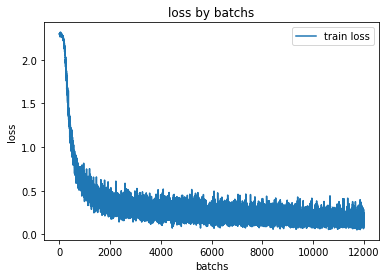

In [71]:
# グラフの描画
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train loss')
plt.xlabel('batchs')
plt.ylabel('loss')
plt.title('loss by batchs')
plt.legend(loc='upper right')
plt.show()

### 認識精度の推移

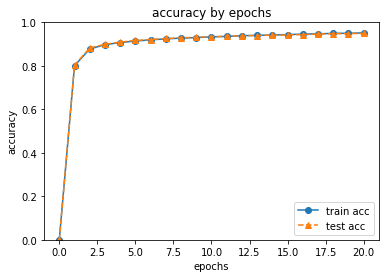

In [72]:
# グラフの描画
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc', marker='o')
plt.plot(x, test_acc_list, label='test acc', linestyle='--', marker='^')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy by epochs')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

#### 【オプション】テストの結果

In [73]:
# テストの実行
test_predict = network.predict(x_test)
print(test_predict.shape)
for index in range(3):
    print('index = ' + str(index))
    print(test_predict[index])
    print(t_test[index])

(10000, 10)
index = 0
[2.99317028e-05 5.85681679e-06 2.16678073e-03 3.08122582e-03
 3.07352840e-06 3.63222966e-05 1.03150549e-08 9.94460558e-01
 1.10229865e-05 2.05218227e-04]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
index = 1
[5.07015334e-03 7.82357906e-04 9.71029932e-01 4.40606449e-03
 6.27861836e-07 2.42598675e-03 1.55845169e-02 8.43839602e-07
 6.99332737e-04 1.84288443e-07]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
index = 2
[9.23544610e-08 9.91749430e-01 2.73803312e-03 6.98070667e-04
 5.28690066e-05 7.25240037e-04 5.08168176e-04 2.90567352e-03
 5.69380713e-04 5.30423122e-05]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


#### 【オプション】エラー結果の確認

error rate = 5.07[%]


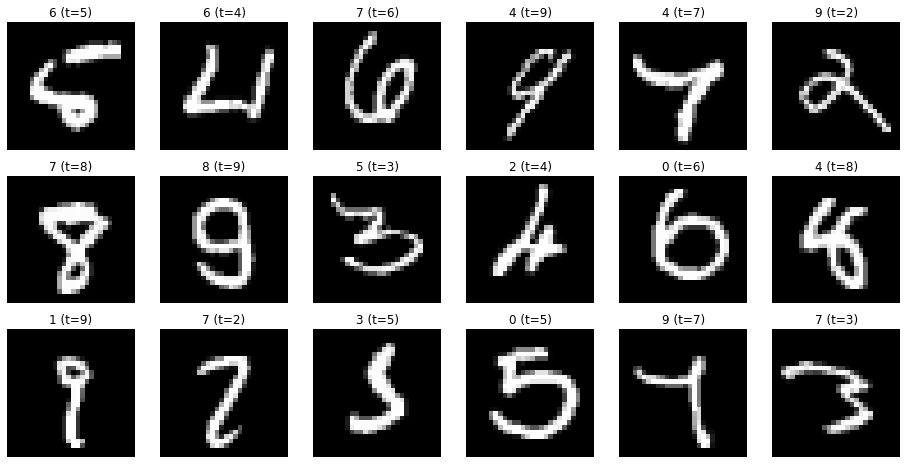

In [74]:
# エラー結果のみの要素を抽出
index_error = np.argmax(test_predict, axis=1) != np.argmax(t_test, axis=1)
error_list = np.arange(len(test_predict))[index_error]
print(f'error rate = {len(error_list) / len(test_predict) * 100}[%]')

# 画像を表示
figure = plt.figure(figsize=(16, 8))
rows, cols = 3, 6
for i in range(rows * cols):
    index = error_list[i]
    img, label_t, label_y = x_test[index], t_test[index].argmax(), test_predict[index].argmax()
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f'{label_y} (t={label_t})')
    plt.axis('off')
    img = img.reshape(28, 28)  # 28x28 に変換
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()